# Imports

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.nn import functional as F

import os
import random
import json
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Read Data

In [3]:
SPECTROGRAM_DIR = os.path.join("output", "dataSet", "spectrogram")
LABEL_PATH = os.path.join("output", "dataSet", "labels.json")

In [4]:
class BoundingBoxDataset(Dataset):
    def __init__(self, spectrogramDir, labelsPath):
        # TODO: Add metadata to the dataset
        # Read labels from file
        self.labelTable: dict = json.load(open(labelsPath))
        # Read all spectrograms from directory
        self.spectrograms = []
        self.labels = []
        
        for fileName in self.labelTable.keys():
            # Read spectrogram image
            img = cv2.imread(os.path.join(spectrogramDir, fileName))
            # Resize the image to 64x64
            img = cv2.resize(img, (64, 64))
            # Convert to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Reshape to (1, 64, 64)
            img = img.reshape(1, 64, 64)
            # Normalize the image
            # 1. Convert to float32
            img = img.astype(np.float32)
            # 2. Subtract min
            img -= np.amin(img)
            # 3. Divide by max
            img /= np.amax(img)
            
            # Convert to tensor
            img = torch.from_numpy(np.array(img))
            
            self.spectrograms.append(img)
            
            # Transform label to np array
            label = np.array(
                [
                    int(
                        self.labelTable[fileName]["isPositive"]
                    )
                ]
            )
            # Convert to float32
            label = label.astype(np.float32)
            self.labels.append(torch.from_numpy(label))
        

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

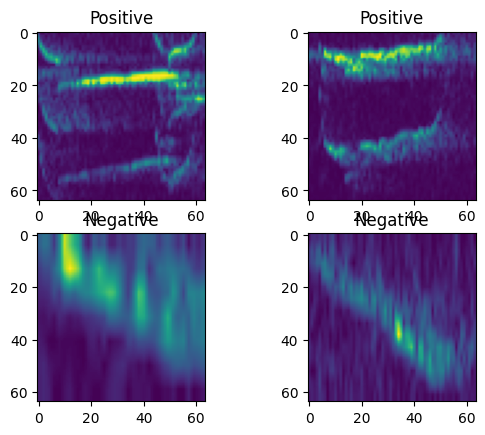

In [5]:
boundingBoxDataset = BoundingBoxDataset(SPECTROGRAM_DIR, LABEL_PATH)
fig, ax = plt.subplots(2, 2)
# Randomly pick 2 positive and 2 negative spectrograms
positiveIdxs = [idx for idx, label in enumerate(boundingBoxDataset.labels) if label == 1]
negativeIdxs = [idx for idx, label in enumerate(boundingBoxDataset.labels) if label == 0]
for i in range(2):
    indx = random.choice(positiveIdxs)
    ax[0][i].imshow(boundingBoxDataset.spectrograms[indx].reshape(64, 64))
    ax[0][i].set_title("Positive")
for i in range(2):
    indx = random.choice(negativeIdxs)
    ax[1][i].imshow(boundingBoxDataset.spectrograms[indx].reshape(64, 64))
    ax[1][i].set_title("Negative")

## Split Train and Test Data

In [6]:
# Split data set.
trainDataSetSize = int(len(boundingBoxDataset) * 0.8)
testDataSetSize = len(boundingBoxDataset) - trainDataSetSize
trainDataSet, testDataSet = random_split(
    boundingBoxDataset,
    [trainDataSetSize, testDataSetSize]
)
# Generate dataloaders
trainLoader = DataLoader(trainDataSet, batch_size=4, shuffle=True)
testLoader = DataLoader(testDataSet, batch_size=4, shuffle=True)

len(trainLoader), len(testLoader)

(23, 6)

# Training

In [7]:
# Defining Model
class BoundingBoxClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape is 1x64x64
        # Convolutional layer (1*64*64 -> 16*62*62)
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # Max pooling layer (16*62*62 -> 16*31*31)
        self.pool1 = nn.MaxPool2d(2, 2)
        # Convolutional layer (16*31*31 -> 32*27*27)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        # Max pooling layer (32*27*27 -> 32*9*9)
        self.pool2 = nn.MaxPool2d(3, 3)
        # Fully connected layer (32*9*9 -> 64)
        self.fc1 = nn.Linear(32 * 9 * 9, 64)
        # Hidden layer (64 -> 32)
        self.fc2 = nn.Linear(64, 32)
        # Output layer (32 -> 1)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        # Convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        # Max pooling layer
        x = self.pool1(x)
        # Convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        # Max pooling layer
        x = self.pool2(x)
        # Flatten layer
        x = x.view(x.size(0), -1)
        # Fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        # Hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        # Output layer
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x

## Utils

In [8]:
def GetModelAccuracy(model, loader):
    """
    Get the accuracy of the model on the given loader.
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [9]:
# Init params
EPOCHS = 10
LEARNING_RATE = 0.001

In [10]:
# Init model
model = BoundingBoxClassifier()
# Move model to GPU if available
model.to(device)

# Defining loss function and optimizer
lossFunc = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
# Get the accuracy of the model on the training set
print("Training set accuracy: {}".format(GetModelAccuracy(model, trainLoader)))
print("Test set accuracy: {}".format(GetModelAccuracy(model, testLoader)))

history = pd.DataFrame(columns=["epoch", "train_acc", "test_acc"])

stepNum = len(trainLoader)
# Training
for epoch in range(EPOCHS):
    print("=====Epoch {}/{}=====".format(epoch + 1, EPOCHS))
    for i, (spectrogram, label) in enumerate(trainLoader):
        # Convert spectrogram and label to tensors
        spectrogram = spectrogram.to(device)
        label = label.to(device)
        
        # Forward pass
        output = model(spectrogram)
        # Compute loss
        loss = lossFunc(output, label)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % (stepNum // 4) == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item():.4f}")
    trainingSetAccuracy = GetModelAccuracy(model, trainLoader)
    testSetAccuracy = GetModelAccuracy(model, testLoader)

d:\Python Projects\RCNN-Audio-Detection\venv\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training set accuracy: 0.449438202247191
Test set accuracy: 0.6956521739130435
=====Epoch 1/10=====
Epoch 1, Batch 5, Loss: 0.7750
Epoch 1, Batch 10, Loss: 0.6763
Epoch 1, Batch 15, Loss: 0.7305
Epoch 1, Batch 20, Loss: 0.6536
Training set accuracy: 0.6179775280898876
Test set accuracy: 0.5217391304347826
=====Epoch 2/10=====
Epoch 2, Batch 5, Loss: 0.4279
Epoch 2, Batch 10, Loss: 0.4265
Epoch 2, Batch 15, Loss: 0.9801
Epoch 2, Batch 20, Loss: 0.5807
Training set accuracy: 0.8426966292134831
Test set accuracy: 1.0
=====Epoch 3/10=====
Epoch 3, Batch 5, Loss: 0.7026
Epoch 3, Batch 10, Loss: 0.4455
Epoch 3, Batch 15, Loss: 0.2486
Epoch 3, Batch 20, Loss: 0.7071
Training set accuracy: 0.8651685393258427
Test set accuracy: 0.782608695652174
=====Epoch 4/10=====
Epoch 4, Batch 5, Loss: 0.1409
Epoch 4, Batch 10, Loss: 0.0926
Epoch 4, Batch 15, Loss: 0.1425
Epoch 4, Batch 20, Loss: 0.1440
Training set accuracy: 0.7303370786516854
Test set accuracy: 0.6086956521739131
=====Epoch 5/10=====
Epoc